In [1]:
# pip install pyspark

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
import time
import psutil

In [2]:
start_time = time.time()

# **EDA and visualization**

In [49]:
hotel_df = pd.read_csv('hotel_bookings.csv')

In [4]:
hotel_df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [51]:
hotel_df.duplicated().sum()

31994

In [52]:
hotel_df = hotel_df.drop_duplicates(keep=False)

In [53]:
spark=SparkSession.builder.appName('Final').getOrCreate()

In [54]:
spark

In [55]:
hotel_spark = spark.createDataFrame(hotel_df)

In [10]:
hotel_spark.show()

+------------+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+--------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+-----+-------+--------------------+-------------+------+---------------------------+-------------------------+------------------+-----------------------+
|       hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|agent|company|days_in_waiting_list|customer_type|   adr|required_car_parking_spaces|to

In [11]:
hotel_spark.printSchema()

root
 |-- hotel: string (nullable = true)
 |-- is_canceled: long (nullable = true)
 |-- lead_time: long (nullable = true)
 |-- arrival_date_year: long (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: long (nullable = true)
 |-- arrival_date_day_of_month: long (nullable = true)
 |-- stays_in_weekend_nights: long (nullable = true)
 |-- stays_in_week_nights: long (nullable = true)
 |-- adults: long (nullable = true)
 |-- children: double (nullable = true)
 |-- babies: long (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: long (nullable = true)
 |-- previous_cancellations: long (nullable = true)
 |-- previous_bookings_not_canceled: long (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullable = true)
 |-- booking_changes: lon

In [12]:
hotel_spark.describe().show()

+-------+------------+-------------------+-----------------+------------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------------------+--------+--------------------+---------+-------+--------------+--------------------+-------------------+----------------------+------------------------------+------------------+------------------+------------------+------------+-----+-------+--------------------+---------------+------------------+---------------------------+-------------------------+------------------+-----------------------+
|summary|       hotel|        is_canceled|        lead_time| arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|            adults|children|              babies|     meal|country|market_segment|distribution_channel|  is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|a

In [13]:
from pyspark.sql.functions import col,isnan, when, count
null_counts = hotel_spark.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in hotel_spark.columns])
null_counts.show()

+-----+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+--------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+-----+-------+--------------------+-------------+---+---------------------------+-------------------------+------------------+-----------------------+
|hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|agent|company|days_in_waiting_list|customer_type|adr|required_car_parking_spaces|total_of_special_reque

In [14]:
from pyspark.sql.functions import count, col, sum as _sum

duplicates_df = hotel_spark.groupBy(hotel_spark.columns).count()

duplicates_df = duplicates_df.filter(col("count") > 1)

duplicate_count = duplicates_df.agg(_sum(col("count") - 1).alias("duplicate_count"))

duplicate_count.show()


+---------------+
|duplicate_count|
+---------------+
|           NULL|
+---------------+



In [15]:
unique_values = {column: hotel_spark.select(column).distinct().count() for column in hotel_spark.columns}
unique_values

{'hotel': 2,
 'is_canceled': 2,
 'lead_time': 437,
 'arrival_date_year': 3,
 'arrival_date_month': 12,
 'arrival_date_week_number': 53,
 'arrival_date_day_of_month': 31,
 'stays_in_weekend_nights': 17,
 'stays_in_week_nights': 35,
 'adults': 14,
 'children': 6,
 'babies': 5,
 'meal': 5,
 'country': 176,
 'market_segment': 8,
 'distribution_channel': 5,
 'is_repeated_guest': 2,
 'previous_cancellations': 11,
 'previous_bookings_not_canceled': 73,
 'reserved_room_type': 10,
 'assigned_room_type': 12,
 'booking_changes': 21,
 'deposit_type': 3,
 'agent': 322,
 'company': 341,
 'days_in_waiting_list': 113,
 'customer_type': 4,
 'adr': 8721,
 'required_car_parking_spaces': 5,
 'total_of_special_requests': 6,
 'reservation_status': 3,
 'reservation_status_date': 922}

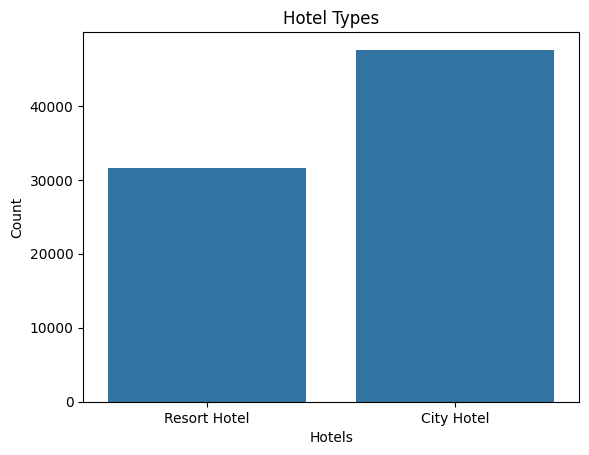

In [17]:
sns.countplot(data=hotel_df, x='hotel')
plt.title('Hotel Types')
plt.xlabel('Hotels')
plt.ylabel('Count')
plt.show()

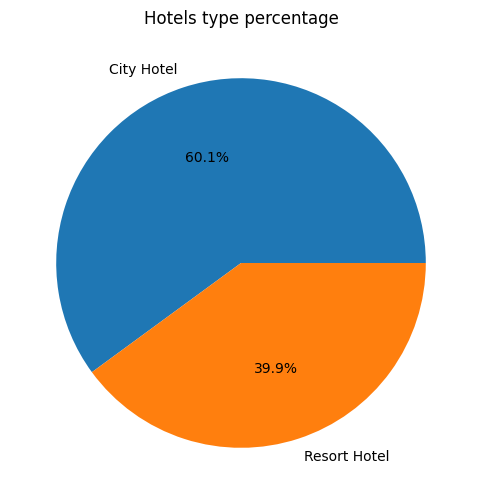

In [20]:
hotel_counts = hotel_df['hotel'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(hotel_counts, labels=['City Hotel', 'Resort Hotel'], autopct='%1.1f%%')
plt.title('Hotels type percentage')
plt.show()

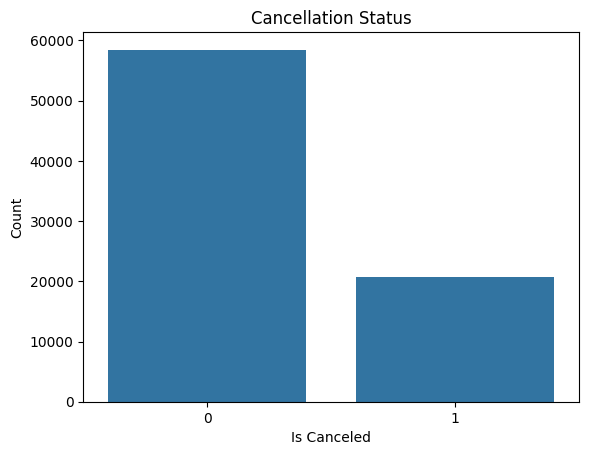

In [21]:
sns.countplot(data=hotel_df, x='is_canceled')
plt.title('Cancellation Status')
plt.xlabel('Is Canceled')
plt.ylabel('Count')
plt.show()

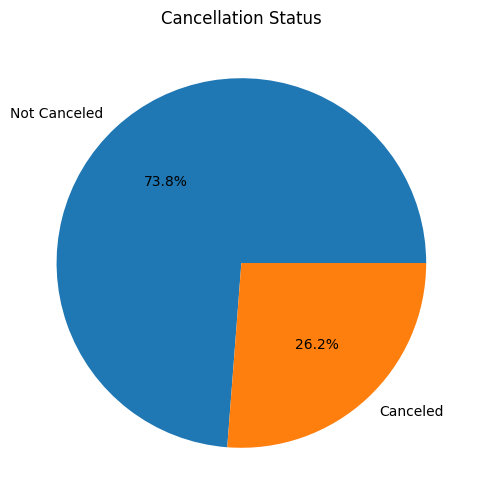

In [22]:
canceled_counts = hotel_df['is_canceled'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(canceled_counts, labels=['Not Canceled', 'Canceled'], autopct='%1.1f%%')
plt.title('Cancellation Status')
plt.show()

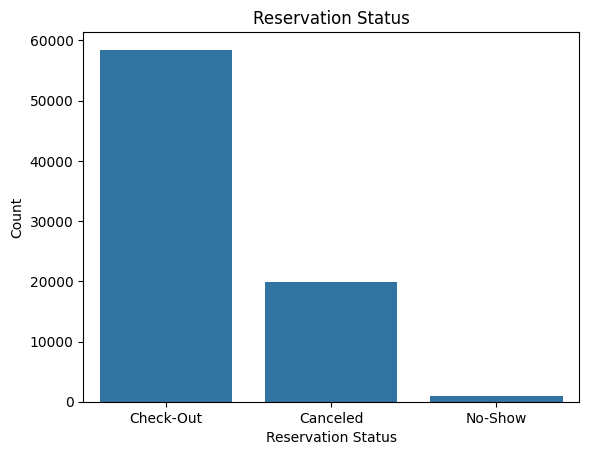

In [23]:
sns.countplot(data=hotel_df, x='reservation_status')
plt.title('Reservation Status')
plt.xlabel('Reservation Status')
plt.ylabel('Count')
plt.show()

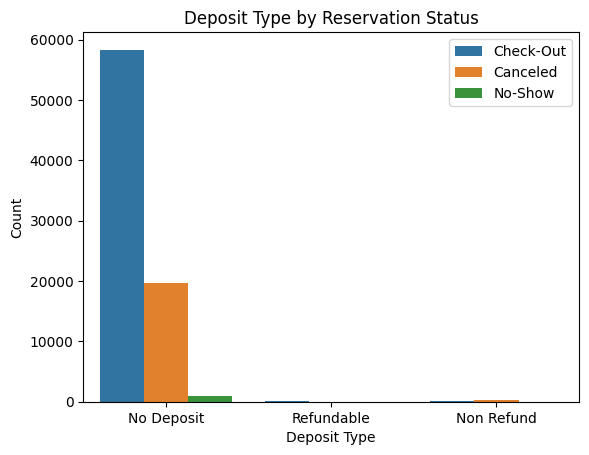

In [31]:
sns.countplot(data=hotel_df, x='deposit_type', hue='reservation_status')
plt.title('Deposit Type by Reservation Status')
plt.xlabel('Deposit Type')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

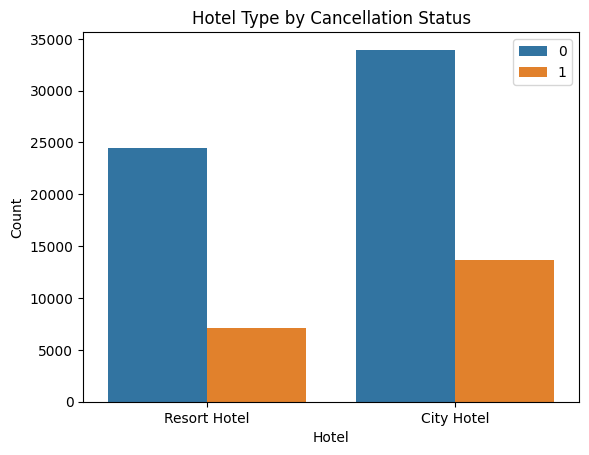

In [32]:
sns.countplot(data=hotel_df, x='hotel', hue='is_canceled')
plt.title('Hotel Type by Cancellation Status')
plt.xlabel('Hotel')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

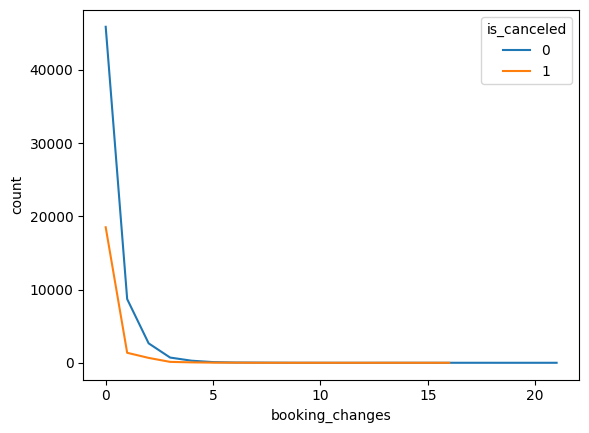

In [27]:
hotel_df_count = hotel_df.groupby(['booking_changes', 'is_canceled']).size().reset_index(name='count')
sns.lineplot(x='booking_changes', y='count', hue='is_canceled', data=hotel_df_count)
plt.show()

In [28]:
hotel_df_count[hotel_df_count['booking_changes'] == 0]

,booking_changes,is_canceled,count
0,0,0,45888
1,0,1,18510


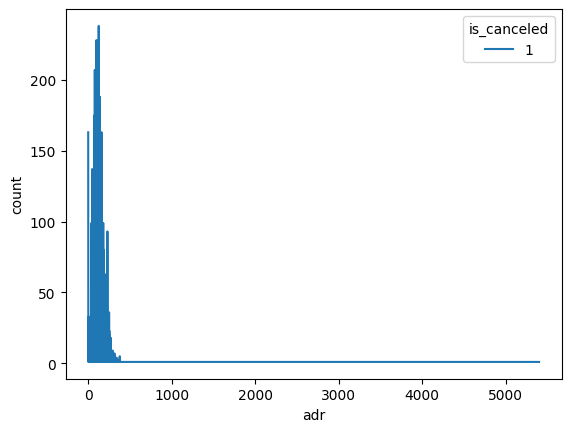

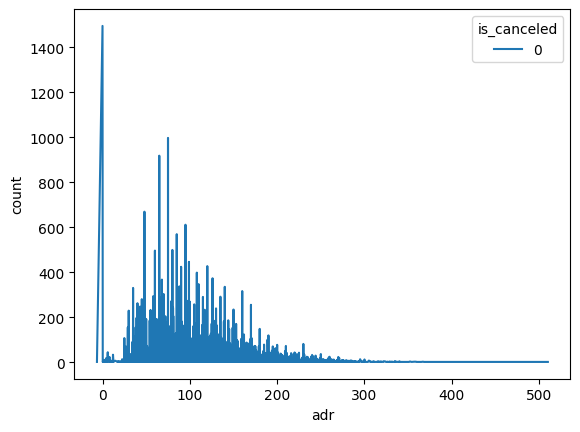

In [29]:
hotel_df_count = hotel_df.groupby(['adr', 'is_canceled']).size().reset_index(name='count')
canceled_df = hotel_df_count[hotel_df_count['is_canceled'] == 1]
not_canceled_df = hotel_df_count[hotel_df_count['is_canceled'] == 0]


sns.lineplot(x='adr', y='count', hue='is_canceled', data=canceled_df)
plt.show()

sns.lineplot(x='adr', y='count', hue='is_canceled', data=not_canceled_df)
plt.show()

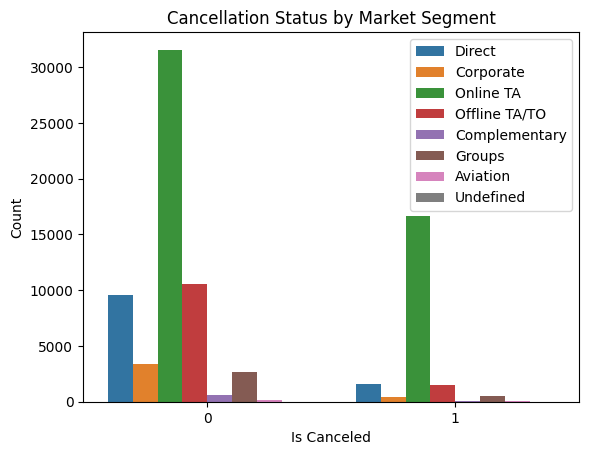

In [30]:
sns.countplot(data=hotel_df, x='is_canceled', hue='market_segment')
plt.title('Cancellation Status by Market Segment')
plt.xlabel('Is Canceled')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [33]:
hotel_df['reserved_room_type'].value_counts()

,count
reserved_room_type,
A,49971
D,16340
E,5745
F,2759
G,2016
C,904
B,889
H,592
L,6


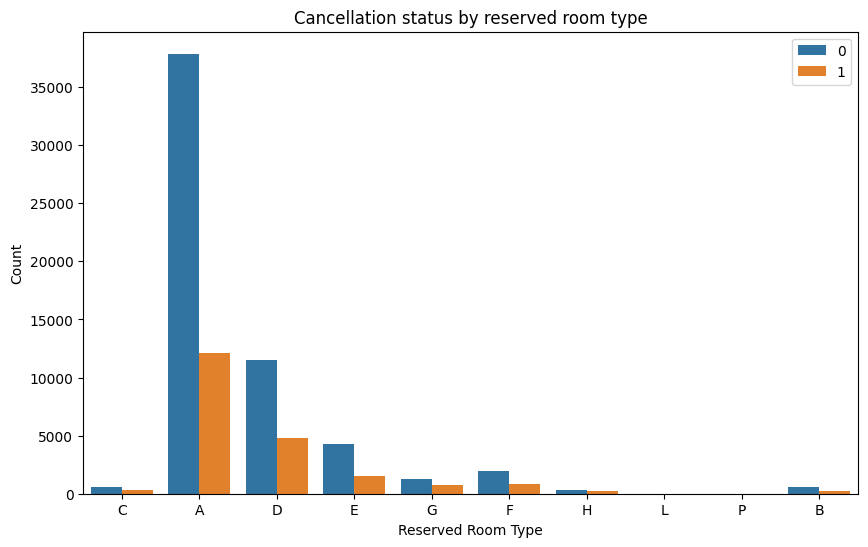

In [34]:
plt.figure(figsize=(10, 6))
sns.countplot(data=hotel_df, x='reserved_room_type', hue='is_canceled')
plt.title('Cancellation status by reserved room type')
plt.xlabel('Reserved Room Type')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

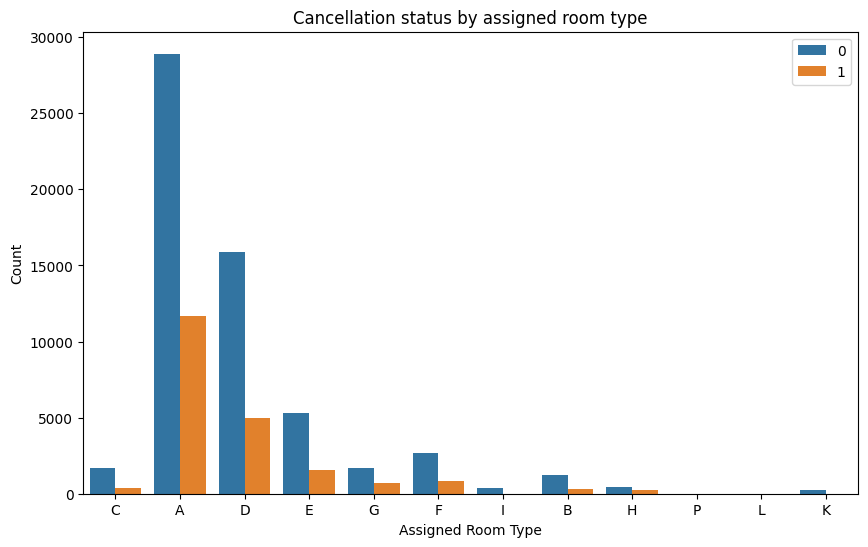

In [35]:
plt.figure(figsize=(10, 6))
sns.countplot(data=hotel_df, x='assigned_room_type', hue='is_canceled')
plt.title('Cancellation status by assigned room type')
plt.xlabel('Assigned Room Type')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [36]:
mistakes = hotel_df[['reserved_room_type', 'assigned_room_type', 'is_canceled']]
mistakes['mistake'] = hotel_df['reserved_room_type'] != hotel_df['assigned_room_type']
mistakes.head()

<ipython-input-36-039dec0e5cd5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mistakes['mistake'] = hotel_df['reserved_room_type'] != hotel_df['assigned_room_type']


,reserved_room_type,assigned_room_type,is_canceled,mistake
0,C,C,0,False
1,C,C,0,False
2,A,C,0,True
3,A,A,0,False
6,C,C,0,False


<ipython-input-37-ff0a5e5fbfcc>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  value1 = [mistake_value[1], mistake_value[0]]


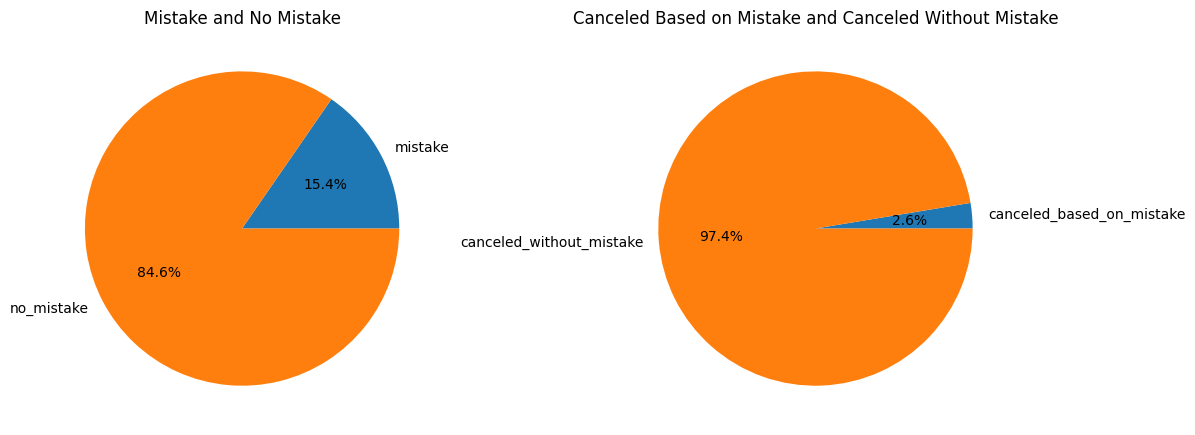

In [37]:
canceled_based_on_mistake = mistakes[mistakes['mistake'] & mistakes['is_canceled'] == 1].shape[0]

canceled_without_mistake = mistakes[(~mistakes['mistake']) & mistakes['is_canceled'] == 1].shape[0]

mistake_value = mistakes['mistake'].value_counts()

label1 = ['mistake', 'no_mistake']
value1 = [mistake_value[1], mistake_value[0]]

label2 = ['canceled_based_on_mistake', 'canceled_without_mistake']
value2 = [canceled_based_on_mistake, canceled_without_mistake]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.pie(value1, labels=label1, autopct='%1.1f%%')
plt.title('Mistake and No Mistake')

plt.subplot(1, 2, 2)
plt.pie(value2, labels=label2, autopct='%1.1f%%')
plt.title('Canceled Based on Mistake and Canceled Without Mistake')

plt.tight_layout()
plt.show()

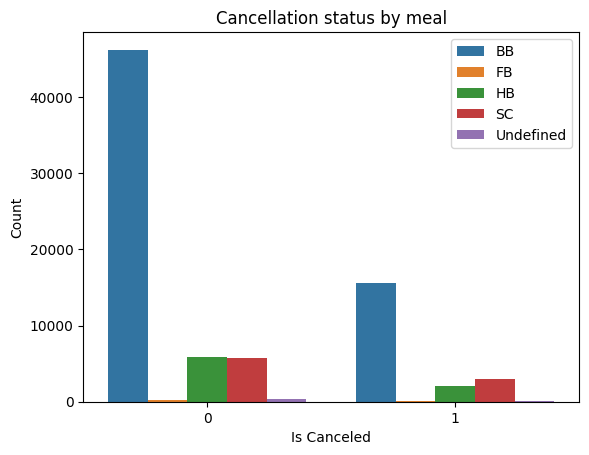

In [38]:
sns.countplot(data=hotel_df, x='is_canceled', hue='meal')
plt.title('Cancellation status by meal')
plt.xlabel('Is Canceled')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [39]:
meal_counts = hotel_df['meal'].value_counts()
meal_counts

,count
meal,
BB,61845
SC,8703
HB,7997
Undefined,371
FB,309


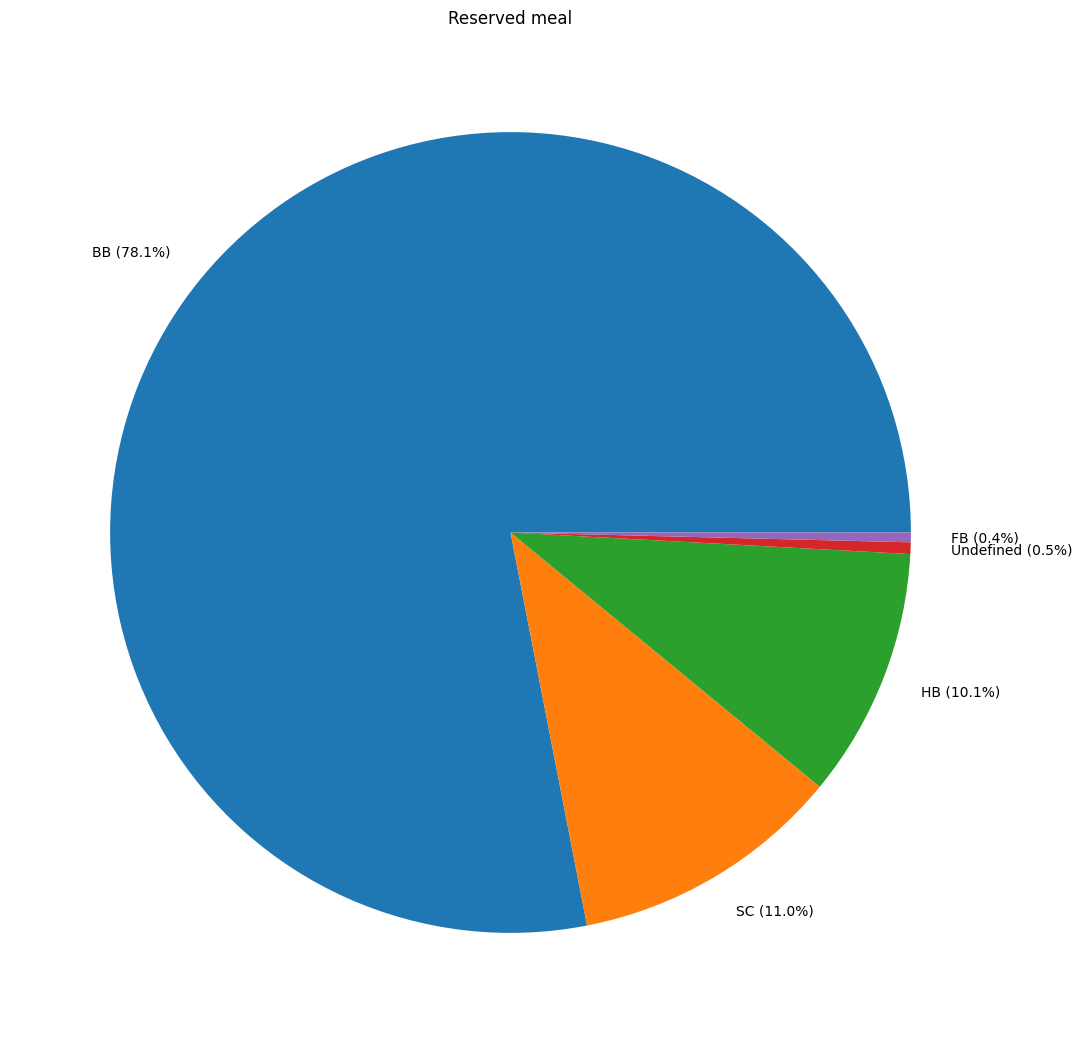

In [40]:
total = meal_counts.sum()
percentages = [f'{label} ({count / total * 100:.1f}%)' for label, count in zip(['BB', 'SC', 'HB', 'Undefined', 'FB'], meal_counts)]

plt.figure(figsize=(13, 13))
plt.pie(meal_counts, labels=percentages, autopct=None)
plt.title('Reserved meal')
plt.show()

# **JSON**

In [ ]:
import json

with open('Berlin.json', 'r') as file:
    data = json.load(file)

booking = pd.json_normalize(data['bookingHotels'])
hotels = pd.json_normalize(data['hotelsComHotels'])

booking.head()

,thumbnail,title,stars,preferredBadge,promotedBadge,location,subwayAccess,sustainability,distanceFromCenter,highlights,link,price.currency,price.value,price.taxesAndCharges,rating.score,rating.scoreDescription,rating.reviews
0,https://cf.bstatic.com/xdata/images/hotel/squa...,Scandic Berlin Kurfürstendamm,NaN,True,True,"Charlottenburg-Wilmersdorf, Berlin",True,Travel Sustainable property,3.2,"[Standard Double Room, Beds: 1 double or 2 twi...",https://www.booking.com/hotel/de/scandic-kurfu...,US$,111,NaN,8.1,Very Good,6506
1,https://cf.bstatic.com/xdata/images/hotel/squa...,Hotel Karlshorst,3.0,False,False,"Lichtenberg, Berlin",False,NaN,10.7,"[Comfort Double Room, Beds: 1 double or 2 twin...",https://www.booking.com/hotel/de/thang-long-re...,US$,68,3.0,6.8,Review score,1254
2,https://cf.bstatic.com/xdata/images/hotel/squa...,Jugendherberge Berlin Ostkreuz,3.0,False,False,"Lichtenberg, Berlin",False,NaN,6.5,"[Triple Room, 3 beds (1 twin, 2 bunk beds)]",https://www.booking.com/hotel/de/jugendherberg...,US$,104,NaN,8.4,Very Good,156
3,https://cf.bstatic.com/xdata/images/hotel/squa...,Hollywood Media Hotel am Kurfürstendamm,4.0,True,False,"Charlottenburg-Wilmersdorf, Berlin",True,Travel Sustainable property,4.1,"[Standard Double or Twin Room, Beds: 1 double ...",https://www.booking.com/hotel/de/hollywood-med...,US$,100,NaN,8.3,Very Good,6679
4,https://cf.bstatic.com/xdata/images/hotel/squa...,Meliá Berlin,4.0,True,True,"Mitte, Berlin",True,Travel Sustainable property,1.0,"[Melia Room, Multiple bed types, Only 1 room l...",https://www.booking.com/hotel/de/melia-berlin....,US$,135,6.0,8.3,Very Good,5519


In [ ]:
hotels.head()

,title,isAd,location,paymentOptions,highlightedAmenities,link,snippet.title,snippet.text,price.currency,price.value,price.withTaxesAndCharges,rating.score,rating.reviews
0,Moxy Berlin Ostbahnhof,True,Friedrichshain,[],[],https://www.hotels.com/ho497828896/moxy-berlin...,Lifestyle Hotel close to Ostbahnhof,"Stylish, pet-friendly hotel in Friedrichshain-...",$,107,120,8.8,596
1,Sheraton Berlin Grand Hotel Esplanade,True,Tiergarten,[],[],https://www.hotels.com/ho109823/sheraton-berli...,Berlin hotel with panoramic windows,An urban oasis of sleek design and intuitive s...,$,163,183,8.6,1000
2,IntercityHotel Berlin Ostbahnhof,False,Friedrichshain,[],[],https://www.hotels.com/ho178251/intercityhotel...,NaN,NaN,$,93,105,8.4,1005
3,URBAN LOFT Berlin,False,Berlin,[],[],https://www.hotels.com/ho2505665600/urban-loft...,NaN,NaN,$,86,97,9,154
4,Dorint Kurfürstendamm Berlin,False,Berlin,"[Fully refundable, Reserve now, pay later]",[],https://www.hotels.com/ho185137/dorint-kurfurs...,NaN,NaN,$,148,166,9.2,1006


In [ ]:
booking_json = booking[['subwayAccess', 'price.value', 'rating.score']]
hotel_json = hotels[['isAd', 'price.value', 'rating.score']]

print(booking_json.head(), '\n')
print('\n')
print('--------------------------------------------------------------------')
print(hotel_json.head())

   subwayAccess  price.value rating.score
0          True          111          8.1
1         False           68          6.8
2         False          104          8.4
3          True          100          8.3
4          True          135          8.3 



--------------------------------------------------------------------
    isAd  price.value rating.score
0   True          107          8.8
1   True          163          8.6
2  False           93          8.4
3  False           86            9
4  False          148          9.2


In [ ]:
json_df = pd.merge(booking_json, hotel_json, on=['price.value', 'rating.score'],
                   how='outer')
json_df.head()

,subwayAccess,price.value,rating.score,isAd
0,True,111,8.1,NaN
1,True,111,8.1,NaN
2,False,68,6.8,NaN
3,False,104,8.4,NaN
4,True,100,8.3,NaN


In [ ]:
json_df.drop('isAd', axis=1, inplace=True)

In [ ]:
json_df.head()

,subwayAccess,price.value,rating.score
0,True,111,8.1
1,True,111,8.1
2,False,68,6.8
3,False,104,8.4
4,True,100,8.3


In [ ]:
json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   subwayAccess  511 non-null    object
 1   price.value   953 non-null    int64 
 2   rating.score  953 non-null    object
dtypes: int64(1), object(2)
memory usage: 22.5+ KB


In [ ]:
json_df.drop('subwayAccess', axis=1, inplace=True)

In [ ]:
json_df.isnull().sum()

,0
price.value,0
rating.score,0


In [ ]:
json_df['rating.score'].value_counts()

,count
rating.score,
8.6,75
8.2,75
8.4,67
8.8,66
9,58
8,55
7.8,52
7.4,38
9.2,37


In [ ]:
json_df['rating.score'].replace("No rating",np.nan, inplace=True)

json_df['rating.score'].fillna(json_df['rating.score'].median(), inplace=True)

In [ ]:
json_df['rating.score'].value_counts()

,count
rating.score,
8.2,83
8.6,75
8.4,67
8.8,66
9.0,58
8.0,55
7.8,52
7.4,38
9.2,37


In [ ]:
conditions = [json_df['rating.score'] >= 8,
              (json_df['rating.score'] < 8) & (json_df['rating.score'] >= 5),
              json_df['rating.score'] < 5]


choice = ['Excellent', 'Good', 'Bad']
json_df['rating'] = np.select(conditions, choice)
json_df.head()

,price.value,rating.score,rating
0,111,8.1,Excellent
1,111,8.1,Excellent
2,68,6.8,Good
3,104,8.4,Excellent
4,100,8.3,Excellent


In [ ]:
json_df['price.value'].value_counts()

,count
price.value,
109,21
120,19
87,19
97,18
98,15
...,...
401,1
168,1
230,1


In [ ]:
json_df1 = json_df[json_df['price.value'] < 1000]

In [ ]:
json_df1

,price.value,rating.score,rating
0,111,8.1,Excellent
1,111,8.1,Excellent
2,68,6.8,Good
3,104,8.4,Excellent
4,100,8.3,Excellent
...,...,...,...
948,185,9.6,Excellent
949,131,9.6,Excellent
950,123,9.0,Excellent
951,86,8.2,Excellent


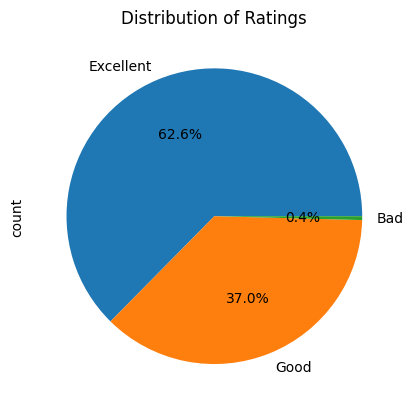

In [ ]:
json_df1['rating'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Ratings')
plt.show()


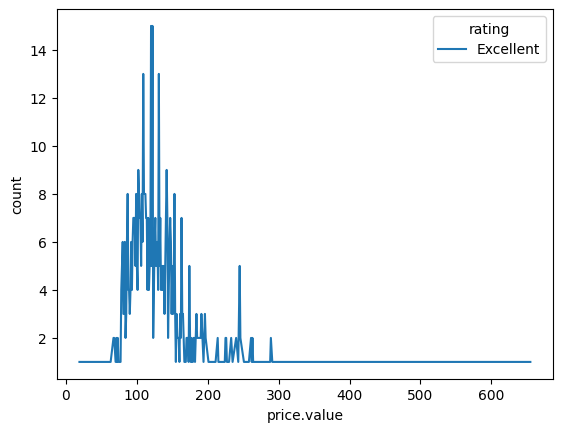

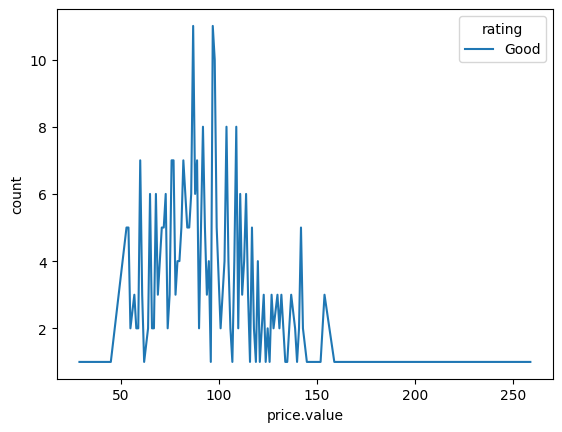

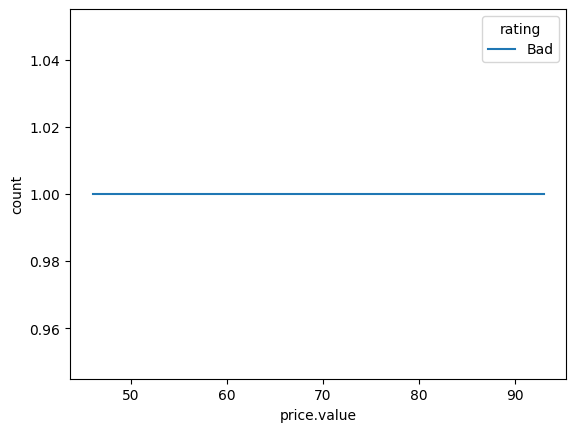

In [ ]:
json_df2 = json_df1.groupby(['price.value', 'rating']).size().reset_index(name='count')

df = json_df2[json_df2['rating'] == 'Excellent']
df1 = json_df2[json_df2['rating'] == 'Good']
df2 = json_df2[json_df2['rating'] == 'Bad']

sns.lineplot(x='price.value', y='count', hue='rating', data=df)
plt.show()

sns.lineplot(x='price.value', y='count', hue='rating', data=df1)
plt.show()

sns.lineplot(x='price.value', y='count', hue='rating', data=df2)
plt.show()

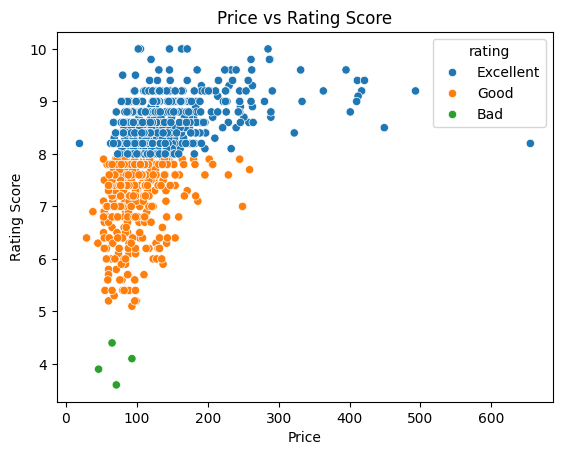

In [ ]:
sns.scatterplot(x='price.value', y='rating.score', hue='rating', data=json_df1)
plt.title('Price vs Rating Score')
plt.xlabel('Price')
plt.ylabel('Rating Score')
plt.show()

# **Preprocessing**

In [56]:
hotel_spark = hotel_spark.drop(*['company', 'agent', 'reservation_status_date', 'country',
                                 'reservation_status', 'arrival_date_year', 'arrival_date_week_number',
                                 'arrival_date_day_of_month', 'babies', 'distribution_channel',
                                 'customer_type', 'deposit_type', 'reserved_room_type', 'assigned_room_type'])
hotel_spark.show()

+------------+-----------+---------+------------------+-----------------------+--------------------+------+--------+----+--------------+-----------------+----------------------+------------------------------+---------------+--------------------+------+---------------------------+-------------------------+
|       hotel|is_canceled|lead_time|arrival_date_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|meal|market_segment|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|booking_changes|days_in_waiting_list|   adr|required_car_parking_spaces|total_of_special_requests|
+------------+-----------+---------+------------------+-----------------------+--------------------+------+--------+----+--------------+-----------------+----------------------+------------------------------+---------------+--------------------+------+---------------------------+-------------------------+
|Resort Hotel|          0|      342|              July|                      0|

In [57]:
from pyspark.ml.feature import VectorAssembler

hotel_spark = hotel_spark.withColumn('hotel', when(col('hotel') == 'Resort Hotel', 0).
                                     when(col('hotel') == 'City Hotel', 1))

hotel_spark = hotel_spark.withColumn('arrival_date_month', when(col('arrival_date_month') == 'January', 1).
                                     when(col('arrival_date_month') == 'February', 2).
                                     when(col('arrival_date_month') == 'March', 3).
                                     when(col('arrival_date_month') == 'April', 4).
                                     when(col('arrival_date_month') == 'May', 5).
                                     when(col('arrival_date_month') == 'June', 6).
                                     when(col('arrival_date_month') == 'July', 7).
                                     when(col('arrival_date_month') == 'August', 8).
                                     when(col('arrival_date_month') == 'September', 9).
                                     when(col('arrival_date_month') == 'October', 10).
                                     when(col('arrival_date_month') == 'November', 11).
                                     when(col('arrival_date_month') == 'December', 12))

hotel_spark = hotel_spark.withColumn('meal', when(col('meal') == 'Undefined', 0).
                                     when(col('meal') == 'BB', 1).
                                     when(col('meal') == 'HB', 2).
                                     when(col('meal') == 'FB', 3).
                                     when(col('meal') == 'SC', 4))

hotel_spark = hotel_spark.withColumn('market_segment', when(col('market_segment') == 'Online TA', 0).
                                     when(col('market_segment') == 'Offline TA/TO', 1).
                                     when(col('market_segment') == 'Groups', 2).
                                     when(col('market_segment') == 'Direct', 3).
                                     when(col('market_segment') == 'Corporate', 4).
                                     when(col('market_segment') == 'Complementary', 5).
                                     when(col('market_segment') == 'Aviation', 6).
                                     when(col('market_segment') == 'Undefined', 7))


In [58]:
hotel_spark.show()

+-----+-----------+---------+------------------+-----------------------+--------------------+------+--------+----+--------------+-----------------+----------------------+------------------------------+---------------+--------------------+------+---------------------------+-------------------------+
|hotel|is_canceled|lead_time|arrival_date_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|meal|market_segment|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|booking_changes|days_in_waiting_list|   adr|required_car_parking_spaces|total_of_special_requests|
+-----+-----------+---------+------------------+-----------------------+--------------------+------+--------+----+--------------+-----------------+----------------------+------------------------------+---------------+--------------------+------+---------------------------+-------------------------+
|    0|          0|      342|                 7|                      0|                   0|     2|

# **Machine Learning**

In [41]:
model_start_time = time.time()

In [59]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline

for column in hotel_spark.columns:
    hotel_spark = hotel_spark.withColumn(column, col(column).cast("integer"))

label_column = 'is_canceled'
features_columns = [col for col in hotel_spark.columns if col != label_column]

assembler = VectorAssembler(inputCols=features_columns, outputCol='features')

rf_classifier = RandomForestClassifier(labelCol=label_column, featuresCol='features', numTrees=50)

pipeline = Pipeline(stages=[assembler, rf_classifier])

train_data, test_data = hotel_spark.randomSplit([0.8, 0.2], seed=42)

model = pipeline.fit(train_data)

predictions = model.transform(test_data)

evaluator_acc = MulticlassClassificationEvaluator(labelCol=label_column, predictionCol='prediction', metricName='accuracy')
accuracy = evaluator_acc.evaluate(predictions)

evaluator_pre = MulticlassClassificationEvaluator(labelCol=label_column, predictionCol='prediction', metricName='weightedPrecision')
precision = evaluator_pre.evaluate(predictions)

evaluator_rec = MulticlassClassificationEvaluator(labelCol=label_column, predictionCol='prediction', metricName='weightedRecall')
recall = evaluator_rec.evaluate(predictions)

evaluator_f1 = MulticlassClassificationEvaluator(labelCol=label_column, predictionCol='prediction', metricName='f1')
f1_score = evaluator_f1.evaluate(predictions)

print(f'Accuracy: {accuracy:.4f}\n')
print(f'Precision: {precision:.4f}\n')
print(f'Recall: {recall:.4f}\n')
print(f'F1 Score: {f1_score:.4f}\n')
model_end_time = time.time()
print(f'Execution Time for the model: {model_end_time - model_start_time} seconds')

Accuracy: 0.7763

Precision: 0.7681

Recall: 0.7763

F1 Score: 0.7337

Execution Time for the model: 204.96590876579285 seconds


In [60]:
end_time = time.time()

cpu = psutil.cpu_percent()

ram = psutil.virtual_memory().percent

print(f"CPU Usage: {cpu}%")
print(f"RAM Usage: {ram}%")
print(f"Execution Time: {end_time - start_time} seconds")

CPU Usage: 35.2%
RAM Usage: 21.5%
Execution Time: 991.0915069580078 seconds
